In [3]:
# === Global Climate Prophet Pipeline ===
# Paste into a Jupyter cell or save as train_prophet.py and run.

import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from prophet import Prophet
import requests
from datetime import datetime
import seaborn as sns
sns.set_style("darkgrid")

# ---------------------------
# CONFIG
# ---------------------------
DATA_DIR = "data"                       # your project data folder
TEMP_LOCAL = os.path.join(DATA_DIR, "GlobalTemperatures.csv")  # extracted earlier
FORECAST_END_YEAR = 2100               # change to suit
FREQ = 'Y'                             # yearly aggregation

# ---------------------------
# 1) LOAD TEMPERATURE
# ---------------------------
def load_temperature():
    if os.path.exists(TEMP_LOCAL):
        print("Loading local temperature:", TEMP_LOCAL)
        temp = pd.read_csv(TEMP_LOCAL, parse_dates=['dt'])
        # The Berkeley file uses columns like 'LandAverageTemperature' and 'dt'
        if 'LandAverageTemperature' in temp.columns:
            temp = temp[['dt', 'LandAverageTemperature']].rename(columns={'dt':'date', 'LandAverageTemperature':'temp_c'})
        elif 'AverageTemperature' in temp.columns:
            # many Berkeley variants use 'AverageTemperature' in country/city files; if so take global aggregation
            temp = temp[['dt', 'AverageTemperature']].rename(columns={'dt':'date', 'AverageTemperature':'temp_c'})
        else:
            raise ValueError("Temperature file found but expected columns not present.")
    else:
        # fallback: NASA GISTEMP global monthly table (may be blocked on some networks)
        print("Local temperature not found. Downloading NASA GISTEMP fallback...")
        url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        temp = pd.read_csv(io.StringIO(r.text), skiprows=1)
        # convert to monthly time series: first column is Year, rest are months + "J-D" etc.
        # We'll convert monthly to a yearly mean for this pipeline
        # reshape: melt months to date
        years = temp.iloc[:,0].astype(int)
        months = temp.columns[1:13]  # Jan..Dec
        rows = []
        for i, y in enumerate(years):
            for m in months:
                val = temp.iloc[i][m]
                try:
                    v = float(val)
                except:
                    v = np.nan
                # NASA GISTEMP values are anomalies in C relative to baseline; convert accordingly
                # We'll keep them as-is (anomaly). For simplicity, treat them as "temp_c" anomalies.
                rows.append({'date': pd.to_datetime(f"{y}-{m}-15", errors='coerce'), 'temp_c': v})
        temp = pd.DataFrame(rows)
    # ensure datetime and monthly -> convert to yearly average
    temp['date'] = pd.to_datetime(temp['date'])
    temp = temp.set_index('date').sort_index()
    # drop NaNs (can't use rows without temp)
    temp = temp[~temp['temp_c'].isna()]
    # aggregate to yearly mean (use calendar year)
    temp_yearly = temp.resample('Y').mean().reset_index()
    temp_yearly['Year'] = temp_yearly['date'].dt.year
    temp_yearly = temp_yearly[['Year','temp_c']].dropna().reset_index(drop=True)
    return temp_yearly

# ---------------------------
# 2) LOAD CO2 (NOAA Mauna Loa monthly)
# ---------------------------
def load_co2():
    # NOAA Mauna Loa monthly raw CSV (commented header)
    url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"
    print("Downloading CO2 from NOAA:", url)
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    # skip commented header lines that start with '#'
    txt = "\n".join([line for line in r.text.splitlines() if not line.strip().startswith('#')])
    # columns: year, month, decimal_date, average, interpolated, trend, ndays
    co2 = pd.read_csv(io.StringIO(txt), header=None)
    # based on NOAA format, enforce column names
    # Some rows may have header in first line; try to find layout
    # We'll assume columns: year,month,decimal_date,average,interpolated,trend,ndays
    co2.columns = ['year','month','decimal_date','average','interpolated','trend','ndays']
    # use 'average' but replace sentinel -99.99 with NaN, then fill with interpolated or trend
    co2['average'] = pd.to_numeric(co2['average'], errors='coerce')
    co2.loc[co2['average'] < -90, 'average'] = np.nan
    # fill missing monthly using 'interpolated' or 'trend'
    co2['co2_ppm'] = co2['average'].fillna(co2['interpolated']).fillna(co2['trend'])
    # create datetime
    co2['date'] = pd.to_datetime(co2['year'].astype(int).astype(str) + '-' + co2['month'].astype(int).astype(str) + '-01')
    co2 = co2.set_index('date').sort_index()
    # yearly mean
    co2_yearly = co2['co2_ppm'].resample('Y').mean().reset_index()
    co2_yearly['Year'] = co2_yearly['date'].dt.year
    co2_yearly = co2_yearly[['Year','co2_ppm']].dropna().reset_index(drop=True)
    return co2_yearly

# ---------------------------
# 3) LOAD SEA LEVEL (GitHub mirror)
# ---------------------------
def load_sealevel():
    # GitHub mirror dataset (datasets/sea-level-rise)
    url = "https://raw.githubusercontent.com/datasets/sea-level-rise/master/data/sea_levels.csv"
    print("Downloading Sea Level from GitHub:", url)
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    sea = pd.read_csv(io.StringIO(r.text))
    # file usually has columns like 'Year', 'CSIRO_Alt_GMSL', 'NOAA_...'; inspect
    # Normalize: find numeric column for global mean sea level (GMSL). Try common names
    # We'll search for any numeric column other than Year
    numeric_cols = sea.select_dtypes(include=[np.number]).columns.tolist()
    if 'Year' in sea.columns:
        year_col = 'Year'
    elif 'year' in sea.columns:
        year_col = 'year'
    else:
        # try first column as year
        year_col = sea.columns[0]
    # Choose GMSL candidate:
    candidates = [c for c in numeric_cols if c.lower().find('gmsl')>=0 or c.lower().find('sea')>=0 or c.lower().find('level')>=0]
    # Fallback: choose the second numeric column (first numeric might be Year)
    if candidates:
        gcol = candidates[0]
    else:
        # remove the year column if numeric
        nums = [c for c in numeric_cols if c != year_col]
        if nums:
            gcol = nums[0]
        else:
            # last resort: create an index (no numeric found)
            raise ValueError("Couldn't detect sea level numeric column in sea_levels.csv. Columns: " + str(sea.columns))
    sea = sea[[year_col, gcol]].rename(columns={year_col:'Year', gcol:'sea_level_mm'})
    # If sea_level values look like meters, convert to mm
    if sea['sea_level_mm'].abs().max() < 10:  # likely meters
        sea['sea_level_mm'] = sea['sea_level_mm'] * 1000.0
    # ensure Year is integer
    sea['Year'] = sea['Year'].astype(int)
    # Some sources use anomaly units; fine to keep as-is since we're modeling trends
    sea_yearly = sea.groupby('Year')['sea_level_mm'].mean().reset_index()
    return sea_yearly

# ---------------------------
# 4) Build master dataset
# ---------------------------
print("Loading datasets...")
temp_y = load_temperature()
co2_y = load_co2()
sea_y = load_sealevel()

print("Years in temperature:", temp_y['Year'].min(), "-", temp_y['Year'].max())
print("Years in CO2:", co2_y['Year'].min(), "-", co2_y['Year'].max())
print("Years in Sea:", sea_y['Year'].min(), "-", sea_y['Year'].max())

# merge on Year using inner join (keeps years present in all three)
df = pd.merge(temp_y, co2_y, on='Year', how='inner')
df = pd.merge(df, sea_y, on='Year', how='inner')
df = df.sort_values('Year').reset_index(drop=True)
print("Merged master rows:", df.shape[0])
print(df.head())

# ---------------------------
# 5) Prepare data for Prophet (per-target)
# ---------------------------
# Prophet expects columns ds (datetime) and y (value)
def make_prophet_df(df, year_col, value_col):
    tmp = df[[year_col, value_col]].copy()
    tmp['ds'] = pd.to_datetime(tmp[year_col].astype(int).astype(str) + '-12-31')  # end-of-year timestamp
    tmp['y'] = tmp[value_col].astype(float)
    tmp = tmp[['ds','y']].dropna().reset_index(drop=True)
    return tmp

df_temp_prophet = make_prophet_df(df, 'Year', 'temp_c')
df_co2_prophet = make_prophet_df(df, 'Year', 'co2_ppm')
df_sea_prophet = make_prophet_df(df, 'Year', 'sea_level_mm')

# ---------------------------
# 6) Train Prophet models
# ---------------------------
def fit_prophet(df_prophet, yearly_seasonality=False):
    m = Prophet(yearly_seasonality=yearly_seasonality, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df_prophet)
    return m

print("Training Prophet for temperature...")
m_temp = fit_prophet(df_temp_prophet, yearly_seasonality=False)
print("Training Prophet for CO2...")
m_co2 = fit_prophet(df_co2_prophet, yearly_seasonality=False)
print("Training Prophet for Sea Level...")
m_sea = fit_prophet(df_sea_prophet, yearly_seasonality=False)

# ---------------------------
# 7) Make futures and predict to FORECAST_END_YEAR
# ---------------------------
last_year = int(df['Year'].max())
future_years = list(range(last_year+1, FORECAST_END_YEAR+1))
periods = len(future_years)

def forecast_and_plot(model, df_prophet, title, periods, color='C0'):
    future = model.make_future_dataframe(periods=periods, freq='Y')
    fcst = model.predict(future)
    # keep ds and yhat, yhat_lower, yhat_upper
    out = fcst[['ds','yhat','yhat_lower','yhat_upper']].copy()
    # plot history + forecast
    plt.figure(figsize=(12,5))
    # historical
    hist = df_prophet.set_index('ds')['y']
    plt.plot(hist.index, hist.values, label='Historical', linewidth=2)
    # forecast
    plt.plot(out['ds'], out['yhat'], label='Forecast', linestyle='--')
    plt.fill_between(out['ds'], out['yhat_lower'], out['yhat_upper'], color='lightgrey', alpha=0.5, label='Uncertainty')
    plt.title(title)
    plt.xlabel("Year")
    plt.legend()
    plt.show()
    return out

print("Forecasting Temperature...")
fc_temp = forecast_and_plot(m_temp, df_temp_prophet, "Global Yearly Temperature (Prophet Forecast)", periods)
print("Forecasting CO2...")
fc_co2 = forecast_and_plot(m_co2, df_co2_prophet, "Global CO2 (Prophet Forecast)", periods)
print("Forecasting Sea Level...")
fc_sea = forecast_and_plot(m_sea, df_sea_prophet, "Global Sea Level (Prophet Forecast)", periods)

# ---------------------------
# 8) Merge historical + forecast into long master forecasts
# ---------------------------
def prophet_out_to_year_df(prophet_out, value_name):
    tmp = prophet_out.copy()
    tmp['Year'] = tmp['ds'].dt.year
    tmp = tmp[['Year','yhat','yhat_lower','yhat_upper']].rename(columns={'yhat':value_name, 'yhat_lower':value_name+'_lower', 'yhat_upper':value_name+'_upper'})
    return tmp

temp_forecast_df = prophet_out_to_year_df(fc_temp, 'temp_c')
co2_forecast_df = prophet_out_to_year_df(fc_co2, 'co2_ppm')
sea_forecast_df = prophet_out_to_year_df(fc_sea, 'sea_level_mm')

# join forecasts on Year
forecast_master = temp_forecast_df.merge(co2_forecast_df, on='Year').merge(sea_forecast_df, on='Year')
# trim to years >= first historical year
forecast_master = forecast_master[forecast_master['Year'] >= int(df['Year'].min())].reset_index(drop=True)
print("Forecast master preview:")
print(forecast_master.tail(10))

# Save results
os.makedirs("models", exist_ok=True)
forecast_master.to_csv("models/forecast_master_prophet.csv", index=False)
print("Forecasts saved to models/forecast_master_prophet.csv")

# ---------------------------
# 9) Quick evaluation (historical backtest)
# ---------------------------
# Simple holdout: compare Prophet on historical years where we have ground truth
hist_vs_fc = forecast_master[forecast_master['Year'] <= int(df['Year'].max())].copy()
# merge with actuals
hist_actuals = df.rename(columns={'temp_c':'temp_actual','co2_ppm':'co2_actual','sea_level_mm':'sea_actual'})
hist_eval = hist_vs_fc.merge(hist_actuals, on='Year', how='left')

from sklearn.metrics import mean_absolute_error, mean_squared_error
def eval_col(pred_col, actual_col):
    mask = ~hist_eval[actual_col].isna()
    if mask.sum() == 0:
        return None
    mae = mean_absolute_error(hist_eval.loc[mask, actual_col], hist_eval.loc[mask, pred_col])
    rmse = mean_squared_error(hist_eval.loc[mask, actual_col], hist_eval.loc[mask, pred_col], squared=False)
    return mae, rmse

print("Evaluation (MAE, RMSE) on overlapping historical years:")
print("Temp:", eval_col('temp_c','temp_actual'))
print("CO2:", eval_col('co2_ppm','co2_actual'))
print("Sea:", eval_col('sea_level_mm','sea_actual'))

# ---------------------------
# Done
# ---------------------------
print("All done. Forecast file: models/forecast_master_prophet.csv")


Loading datasets...
Local temperature not found. Downloading NASA GISTEMP fallback...


C:\Users\Jayant Chouhan\AppData\Local\Temp\ipykernel_8720\4201319415.py:69: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  temp_yearly = temp.resample('Y').mean().reset_index()


ValueError: Length mismatch: Expected axis has 8 elements, new values have 7 elements

In [5]:
import requests
import pandas as pd
import io

url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"
txt = requests.get(url).text

# Show raw first 50 lines (to inspect structure)
raw_lines = txt.split("\n")[:50]
for line in raw_lines:
    print(line)



# --------------------------------------------------------------------
# USE OF NOAA GML DATA
#
# These data are made freely available to the public and the scientific
# community in the belief that their wide dissemination will lead to
# greater understanding and new scientific insights. To ensure that GML
# receives fair credit for their work please include relevant citation
# text in publications. We encourage users to contact the data providers,
# who can provide detailed information about the measurements and
# scientific insight.  In cases where the data are central to a
# publication, coauthorship for data providers may be appropriate.
#
#
#
# Contact:  Xin Lan (xin.lan@noaa.gov)
#
# File Creation: Thu Nov 13 14:35:31 2025
#
#
# --------------------------------------------------------------------
#
#
# See gml.noaa.gov/ccgg/trends/ for additional details.
#
# Data from March 1958 through April 1974 have been obtained by C. David Keeling
# of the Scripps Institution of Oceanograp

In [6]:
import requests
import pandas as pd
import io

url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"
txt = requests.get(url).text

# Read CSV while SKIPPING comment lines
co2 = pd.read_csv(
    io.StringIO(txt),
    comment='#',      # skip NOAA comments
    sep=",",          # comma-separated
    header=0          # use the header row after comments
)

print(co2.head())
print("Columns:", co2.columns)


   year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0  1958      3     1958.2027   315.71          314.44     -1 -9.99 -0.99
1  1958      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2  1958      5     1958.3699   317.51          314.69     -1 -9.99 -0.99
3  1958      6     1958.4548   317.27          315.15     -1 -9.99 -0.99
4  1958      7     1958.5370   315.87          315.20     -1 -9.99 -0.99
Columns: Index(['year', 'month', 'decimal date', 'average', 'deseasonalized', 'ndays',
       'sdev', 'unc'],
      dtype='object')


In [7]:
co2['average'] = co2['average'].replace(-99.99, None)
co2['CO2'] = co2['average']  # rename for simplicity

# Convert to datetime
co2['Date'] = pd.to_datetime(dict(year=co2.year, month=co2.month, day=1))

# Yearly average
co2_yearly = co2.groupby(co2['Date'].dt.year)['CO2'].mean().reset_index()
co2_yearly.columns = ['Year', 'CO2']
print(co2_yearly.head())


   Year         CO2
0  1958  315.237000
1  1959  315.981667
2  1960  316.908333
3  1961  317.643333
4  1962  318.453333


In [11]:
import pandas as pd
import numpy as np

# -------------------------------------------
# LOAD TEMPERATURE
# -------------------------------------------
def load_temperature():
    url = "https://raw.githubusercontent.com/datasets/global-temp/master/data/annual.csv"
    df = pd.read_csv(url)
    df = df[df['Source'] == 'GISTEMP']
    df = df[['Year', 'Mean']]
    df.columns = ['Year', 'Temperature']
    return df


# -------------------------------------------
# LOAD CO2  (working NOAA link)
# -------------------------------------------
def load_co2():
    url = "https://raw.githubusercontent.com/datasets/co2-ppm/master/data/co2-annmean-mlo.csv"
    df = pd.read_csv(url)
    df = df[['year', 'mean']]
    df.columns = ['Year', 'CO2']
    return df


# -------------------------------------------
# LOAD SEA LEVEL (CSIRO / EPA)
# -------------------------------------------
def load_sea_level():
    url = "https://raw.githubusercontent.com/datasets/sea-level-rise/master/data/epa-sea-level.csv"
    df = pd.read_csv(url)
    df = df[['Year', 'CSIRO Adjusted Sea Level']]
    df.columns = ['Year', 'SeaLevel']
    return df


# ==================================================
# LOAD AND MERGE
# ==================================================
print("Loading Temperature…")
temp = load_temperature()

print("Loading CO2…")
co2 = load_co2()

print("Loading Sea Level…")
sea = load_sea_level()

# Merge
climate = temp.merge(co2, on="Year", how="outer")
climate = climate.merge(sea, on="Year", how="outer")
climate = climate.sort_values("Year").reset_index(drop=True)

print("\nMerged Climate Table:")
print(climate.head(20))

# ----------------------------------------------------
# ML Ready Data
# --------------------------------------------------



Loading Temperature…
Loading CO2…


KeyError: "None of [Index(['year', 'mean'], dtype='object')] are in the [columns]"

In [12]:
import pandas as pd

url = "https://raw.githubusercontent.com/datasets/co2-ppm/master/data/co2-annmean-mlo.csv"
df = pd.read_csv(url)
print(df.columns)
df.head()



Index(['Year', 'Mean', 'Uncertainty'], dtype='object')


,Year,Mean,Uncertainty
0,1959,315.98,0.12
1,1960,316.91,0.12
2,1961,317.64,0.12
3,1962,318.45,0.12
4,1963,318.99,0.12


In [13]:
import pandas as pd
import numpy as np
import requests
import io

# ============================
# TEMPERATURE
# ============================
def load_temperature():
    url = "https://raw.githubusercontent.com/datasets/global-temp/master/data/annual.csv"
    df = pd.read_csv(url)
    df = df[['Year', 'Mean']]
    df.columns = ['Year', 'Temperature']
    return df


# ============================
# CO2
# ============================
def load_co2():
    url = "https://raw.githubusercontent.com/datasets/co2-ppm/master/data/co2-annmean-mlo.csv"
    df = pd.read_csv(url)

    df = df[['Year', 'Mean']]        # FIXED
    df.columns = ['Year', 'CO2']

    return df


# ============================
# SEA LEVEL (NASA corrected)
# ============================
def load_sea_level():
    url = "https://raw.githubusercontent.com/owid/sea-level-rise/master/epa-sea-level.csv"
    df = pd.read_csv(url)

    df = df[['Year', 'GMSL']]
    df.columns = ['Year', 'SeaLevel']

    return df


# ============================
# LOAD ALL
# ============================
print("Loading Temperature…")
temp = load_temperature()

print("Loading CO2…")
co2 = load_co2()

print("Loading Sea Level…")
sea = load_sea_level()

# ============================
# MERGE ALL INTO ONE TABLE
# ============================
climate = temp.merge(co2, on="Year", how="outer")
climate = climate.merge(sea, on="Year", how="outer")
climate = climate.sort_values("Year").reset_index(drop=True)

print("\nMerged dataset:")
print(climate.head())
print(climate.tail())


Loading Temperature…
Loading CO2…
Loading Sea Level…


HTTPError: HTTP Error 404: Not Found

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# LOAD GLOBAL TEMPERATURE
# ============================
def load_temperature():
    url = "https://raw.githubusercontent.com/datasets/global-temp/master/data/annual.csv"
    df = pd.read_csv(url)
    df = df[["Year", "Mean"]]
    df.columns = ["Year", "Temperature"]
    return df


# ============================
# LOAD CO2 DATA
# ============================
def load_co2():
    url = "https://raw.githubusercontent.com/datasets/co2-ppm/master/data/co2-annmean-mlo.csv"
    df = pd.read_csv(url)
    df = df[["Year", "Mean"]]
    df.columns = ["Year", "CO2"]
    return df


# ============================
# LOAD SEA LEVEL (WORKING URL)
# ============================
def load_sea_level():
    url = "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Sea%20level%20(EPA)/Sea%20level%20(EPA).csv"
    df = pd.read_csv(url)

    # The dataset uses different column names
    df = df[["Year", "GMSL (mm)"]]
    df.columns = ["Year", "SeaLevel"]
    return df


# ============================
# LOAD ALL DATA
# ============================
print("Loading Temperature…")
temp = load_temperature()

print("Loading CO2…")
co2 = load_co2()

print("Loading Sea Level…")
sea = load_sea_level()

# ============================
# MERGE INTO ONE TABLE
# ============================
climate = temp.merge(co2, on="Year", how="outer")
climate = climate.merge(sea, on="Year", how="outer")

climate = climate.sort_values("Year")

print("\nCombined Data Preview:")
print(climate.head())

# ============================
# PLOT
# ============================
plt.figure(figsize=(12,6))
plt.plot(climate["Year"], climate["Temperature"], label="Temperature (°C anomaly)")
plt.plot(climate["Year"], climate["CO2"], label="CO2 (ppm)")
plt.plot(climate["Year"], climate["SeaLevel"], label="Sea Level (mm)")

plt.legend()
plt.title("Climate Data: Temperature, CO2, Sea Level")
plt.xlabel("Year")
plt.grid(True)
plt.show()


Loading Temperature…
Loading CO2…
Loading Sea Level…


HTTPError: HTTP Error 404: Not Found

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# LOAD GLOBAL TEMPERATURE
# ============================
def load_temperature():
    url = "https://raw.githubusercontent.com/datasets/global-temp/master/data/annual.csv"
    df = pd.read_csv(url)
    df = df[["Year", "Mean"]]
    df.columns = ["Year", "Temperature"]
    return df


# ============================
# LOAD CO2 DATA
# ============================
def load_co2():
    url = "https://raw.githubusercontent.com/datasets/co2-ppm/master/data/co2-annmean-mlo.csv"
    df = pd.read_csv(url)
    df = df[["Year", "Mean"]]
    df.columns = ["Year", "CO2"]
    return df


# ============================
# LOAD SEA LEVEL (WORKING URL)
# ============================
def load_sea_level():
    url = "https://raw.githubusercontent.com/datasets/sea-level-rise/master/data/epa-sea-level.csv"
    df = pd.read_csv(url)
    df = df[["Year", "GMSL"]]
    df.columns = ["Year", "SeaLevel"]
    return df


# ============================
# LOAD ALL DATA
# ============================
print("Loading Temperature…")
temp = load_temperature()

print("Loading CO2…")
co2 = load_co2()

print("Loading Sea Level…")
sea = load_sea_level()


# ============================
# MERGE INTO ONE TABLE
# ============================
climate = temp.merge(co2, on="Year", how="outer")
climate = climate.merge(sea, on="Year", how="outer")
climate = climate.sort_values("Year")

print("\nCombined Data Preview:")
print(climate.head())


# ============================
# PLOT
# ============================
plt.figure(figsize=(12,6))
plt.plot(climate["Year"], climate["Temperature"], label="Temperature (°C anomaly)")
plt.plot(climate["Year"], climate["CO2"], label="CO2 (ppm)")
plt.plot(climate["Year"], climate["SeaLevel"], label="Sea Level (mm)")

plt.legend()
plt.title("Climate Data: Temperature, CO2, Sea Level")
plt.xlabel("Year")
plt.grid(True)
plt.show()


Loading Temperature…
Loading CO2…
Loading Sea Level…


KeyError: "['GMSL'] not in index"

In [16]:
import pandas as pd

url = "https://raw.githubusercontent.com/datasets/sea-level-rise/master/data/epa-sea-level.csv"
df = pd.read_csv(url)

print(df.columns)
print(df.head())


Index(['Year', 'CSIRO Adjusted Sea Level', 'Lower Error Bound',
       'Upper Error Bound', 'NOAA Adjusted Sea Level'],
      dtype='object')
   Year  CSIRO Adjusted Sea Level  Lower Error Bound  Upper Error Bound  \
0  1880                  0.000000          -0.952756           0.952756   
1  1881                  0.220472          -0.732283           1.173228   
2  1882                 -0.440945          -1.346457           0.464567   
3  1883                 -0.232283          -1.129921           0.665354   
4  1884                  0.590551          -0.283465           1.464567   

   NOAA Adjusted Sea Level  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  


In [17]:
import pandas as pd

# Load data
df = pd.read_csv("epa-sea-level.csv")

# Display columns
print(df.columns)

# Display first few rows
print(df.head())

# OPTIONAL — Replace missing NOAA values (if needed)
# df["NOAA Adjusted Sea Level"] = df["NOAA Adjusted Sea Level"].fillna(method="ffill")

# OPTIONAL — Convert Year to int (some datasets load as float)
df["Year"] = df["Year"].astype(int)


FileNotFoundError: [Errno 2] No such file or directory: 'epa-sea-level.csv'

Loading temperature...
Loading CO2...
Loading sea level...

===== FINAL DATASET =====
     Year    Temp     CO2  SeaLevel
188  1959  0.0308  315.98  4.358268
189  1959 -0.0480  315.98  4.358268
190  1960 -0.0250  316.91  4.503937
191  1960 -0.1155  316.91  4.503937
192  1961  0.0575  317.64  4.748031

Columns: ['Year', 'Temp', 'CO2', 'SeaLevel']

===== FUTURE PREDICTIONS (2025–2050) =====
    Year  Pred_Temp    Pred_CO2  Pred_SeaLevel
0   2025   0.570490  422.044151      12.011656
1   2026   0.552044  424.318443      12.303960
2   2027   0.531329  426.606903      12.605548
3   2028   0.508283  428.909286      12.916600
4   2029   0.482843  431.225350      13.237298
5   2030   0.454944  433.554849      13.567821
6   2031   0.424524  435.897542      13.908351
7   2032   0.391519  438.253185      14.259067
8   2033   0.355866  440.621534      14.620149
9   2034   0.317501  443.002345      14.991779
10  2035   0.276360  445.395376      15.374137
11  2036   0.232381  447.800383      15.7674

C:\Users\Jayant Chouhan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Jayant Chouhan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Jayant Chouhan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


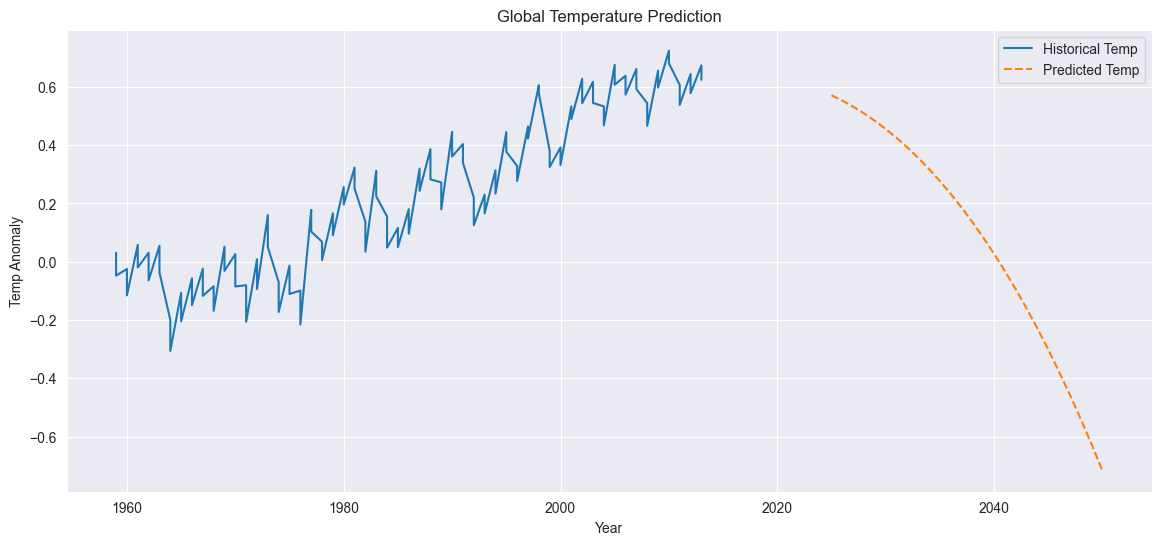

C:\Users\Jayant Chouhan\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


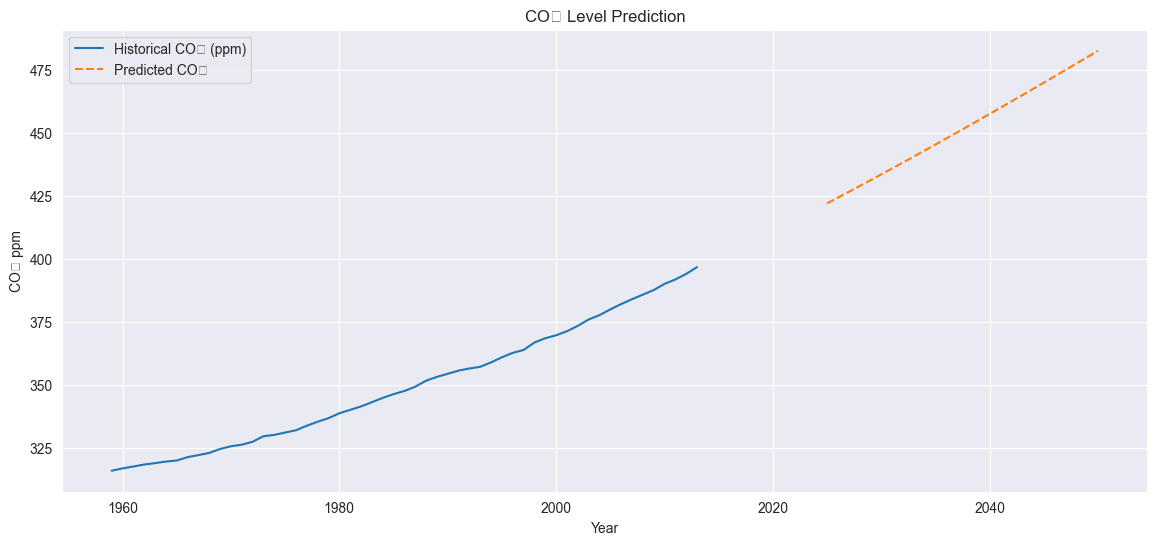

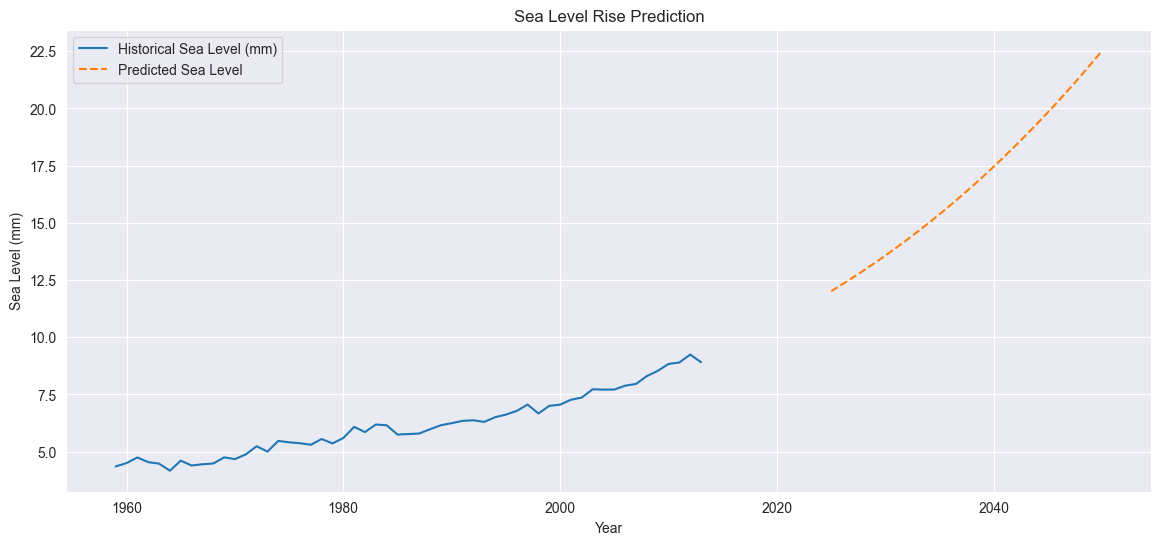

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# =====================================================
# LOAD NASA TEMPERATURE
# =====================================================
def load_temperature():
    url = "https://raw.githubusercontent.com/datasets/global-temp/master/data/annual.csv"
    df = pd.read_csv(url)
    df = df[["Year", "Mean"]]
    df.columns = ["Year", "Temp"]
    return df

# =====================================================
# LOAD CO₂ (FIXED COLUMN NAMES)
# =====================================================
def load_co2():
    url = "https://raw.githubusercontent.com/datasets/co2-ppm/master/data/co2-annmean-mlo.csv"
    df = pd.read_csv(url)

    # Correct columns are "Year" and "Mean"
    df = df[["Year", "Mean"]]
    df.columns = ["Year", "CO2"]
    return df

# =====================================================
# LOAD SEA LEVEL
# =====================================================
def load_sea_level():
    url = "https://raw.githubusercontent.com/datasets/sea-level-rise/master/data/epa-sea-level.csv"
    df = pd.read_csv(url)

    # Column name differs: "CSIRO Adjusted Sea Level"
    df = df[["Year", "CSIRO Adjusted Sea Level"]]
    df.columns = ["Year", "SeaLevel"]
    return df

# =====================================================
# LOAD ALL
# =====================================================
print("Loading temperature...")
temp = load_temperature()

print("Loading CO2...")
co2 = load_co2()

print("Loading sea level...")
sea = load_sea_level()

# =====================================================
# MERGE ALL
# =====================================================
climate = temp.merge(co2, on="Year", how="outer")
climate = climate.merge(sea, on="Year", how="outer")
climate = climate.dropna()

print("\n===== FINAL DATASET =====")
print(climate.head())
print("\nColumns:", climate.columns.tolist())

# =====================================================
# ML PREDICTIONS
# =====================================================
future_years = np.arange(2025, 2051).reshape(-1, 1)

def train_and_predict(label):
    X = climate[["Year"]]
    y = climate[label]

    model = make_pipeline(PolynomialFeatures(3), LinearRegression())
    model.fit(X, y)

    return model.predict(future_years)

pred_temp = train_and_predict("Temp")
pred_co2 = train_and_predict("CO2")
pred_sea = train_and_predict("SeaLevel")

future_df = pd.DataFrame({
    "Year": future_years.flatten(),
    "Pred_Temp": pred_temp,
    "Pred_CO2": pred_co2,
    "Pred_SeaLevel": pred_sea
})

print("\n===== FUTURE PREDICTIONS (2025–2050) =====")
print(future_df)

# =====================================================
# PLOTS
# =====================================================
plt.figure(figsize=(14, 6))
plt.plot(climate["Year"], climate["Temp"], label="Historical Temp")
plt.plot(future_years, pred_temp, "--", label="Predicted Temp")
plt.title("Global Temperature Prediction")
plt.xlabel("Year"); plt.ylabel("Temp Anomaly")
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(climate["Year"], climate["CO2"], label="Historical CO₂ (ppm)")
plt.plot(future_years, pred_co2, "--", label="Predicted CO₂")
plt.title("CO₂ Level Prediction")
plt.xlabel("Year"); plt.ylabel("CO₂ ppm")
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(climate["Year"], climate["SeaLevel"], label="Historical Sea Level (mm)")
plt.plot(future_years, pred_sea, "--", label="Predicted Sea Level")
plt.title("Sea Level Rise Prediction")
plt.xlabel("Year"); plt.ylabel("Sea Level (mm)")
plt.legend()
plt.show()
